# This Notebook was mainly created for the Capstone Project of this Course.

In [ ]:
In this notebook, we will assist a tourist in selecting which venues to visit, going from the selection og borough first, then neighborhoods, and then the top 10 venues. This will spare 

### Importing the necessary dependencies

In [1]:
# Let's import the necessary dependencies
import random # library for random number generation
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.cm as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install geopy # To install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install folium # To install folium
import folium # map rendering library


print('Libraries imported.')

     |████████████████████████████████| 102kB 7.5MB/s ta 0:00:011
Libraries imported.


## Step 1 - Creating the necessary Dataframes

### 1.1 Retreiving Data

In [2]:
# Let's retreive the data from the IBM server. This dataset was made available there by the course instructor.
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
print('json file loaded!')

json file loaded!


In [4]:
#newyork_data <-- uncommenting this line would display the huge content of this dictionary. You can run this line at your covenience.

All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data, and then transform it into a pandas dataframe.

In [5]:
neighborhoods_data = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names) # Empty dataframe
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
print("Shape of Dataframe:", neighborhoods.shape)
neighborhoods.head()

Shape of Dataframe: (306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


### 1.2 Use geopy library to get the latitude and longitude values of New York City.

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Let's create a map of New York with neighborhoods superimposed on top.

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# generate colors for the different borough for better visualization
def colorgenereation(borough):
    if borough == 'Bronx':
        color = 'red'
    elif borough == 'Manhattan':
        color = 'blue'
    elif borough == 'Brooklyn':
        color = 'yellow'
    elif borough == 'Queens':
        color = 'purple'
    else:
        color = 'green'
    return (color)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= colorgenereation(borough),
        fill=True,
        fill_color = colorgenereation(borough),
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Step 2 - Exploring New York City

We are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### 2.1 Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = '4NHQ1ETBLEG4Q5FIAYPA221E5PCFE5SWUWSWHHCIOQXEDFN2' # your Foursquare ID WBR0WSJCSHUZIU2BR1BOD32R45AX24NPQZBFGJWHVDGWM5CH
CLIENT_SECRET = 'II4U25NSQBII0CPXHUV5LFZSPYZVUJ5KRQSIMP4L52EEFATH' # your Foursquare Secret 0SHD2S5ZT4AMTTSDBABRZU0DLFGBKGBILIFVO11BMPFCSXE1
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4NHQ1ETBLEG4Q5FIAYPA221E5PCFE5SWUWSWHHCIOQXEDFN2
CLIENT_SECRET:II4U25NSQBII0CPXHUV5LFZSPYZVUJ5KRQSIMP4L52EEFATH


#### 2.2 Exploring Neighborhoods in New York City

Let's retreive the top 20 venues in each neighborhood in the city of New York within a 500 m radius from the center of each nei

In [13]:
def getNearbyVenues(borough, names, latitudes, longitudes, radius=500, LIMIT = 20):
    
    venues_list=[]
    for borough, name, lat, lng in zip(borough, names, latitudes, longitudes):
          
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue 
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
newyork_venues = getNearbyVenues(borough = neighborhoods['Borough'], names= neighborhoods['Neighborhood'], latitudes= neighborhoods['Latitude'], longitudes= neighborhoods['Longitude'])
newyork_venues.head(10)

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
3,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Bronx,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
5,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
6,Bronx,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
7,Bronx,Wakefield,40.894705,-73.847201,Pitman Deli,40.896744,-73.844398,Food
8,Bronx,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
9,Bronx,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat


In [15]:
newyork_venues.shape

(4807, 8)

It looks like we have quite a lot of data at hand. let's try to break it down and extract some insights to assist our tourist in selecting the best neighborhood to visit first.

Let's extract meaningful insights on the Borough level first.

In [16]:
grouped_ny= newyork_venues.groupby('Borough').count().reset_index()
grouped_ny

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,842,842,842,842,842,842,842
1,Brooklyn,1213,1213,1213,1213,1213,1213,1213
2,Manhattan,798,798,798,798,798,798,798
3,Queens,1249,1249,1249,1249,1249,1249,1249
4,Staten Island,705,705,705,705,705,705,705


In [17]:
neighb_grouped = neighborhoods.groupby('Borough').count().reset_index()
neighb_grouped.drop(['Latitude', 'Longitude'], axis = 1, inplace = True)
neighb_grouped.columns = ['Borough', 'Neighborhood_Count']
neighb_grouped

,Borough,Neighborhood_Count
0,Bronx,52
1,Brooklyn,70
2,Manhattan,40
3,Queens,81
4,Staten Island,63


In [18]:
grouped_ny = pd.merge(grouped_ny, neighb_grouped, on = 'Borough')
grouped_ny

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood_Count
0,Bronx,842,842,842,842,842,842,842,52
1,Brooklyn,1213,1213,1213,1213,1213,1213,1213,70
2,Manhattan,798,798,798,798,798,798,798,40
3,Queens,1249,1249,1249,1249,1249,1249,1249,81
4,Staten Island,705,705,705,705,705,705,705,63


In [19]:
grouped_ny['Density'] = grouped_ny['Venue']/grouped_ny['Neighborhood_Count']
grouped_ny

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood_Count,Density
0,Bronx,842,842,842,842,842,842,842,52,16.192308
1,Brooklyn,1213,1213,1213,1213,1213,1213,1213,70,17.328571
2,Manhattan,798,798,798,798,798,798,798,40,19.950000
3,Queens,1249,1249,1249,1249,1249,1249,1249,81,15.419753
4,Staten Island,705,705,705,705,705,705,705,63,11.190476


Let's visualize the density of venues for each borough.

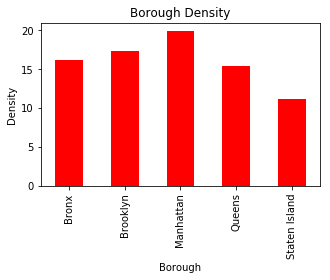

In [21]:
grouped_ny.set_index('Borough', inplace = True)
#grouped_ny

grouped_ny['Density'].plot(kind = 'bar', color = 'red', figsize = (5,3), rot = 90)

plt.title('Borough Density')
plt.ylabel('Density')
plt.xlabel('Borough')

plt.show()

Clearly Manhattan has higher venue density compared to the other boroughs, but not by much. This can be a key indicator to our tourist who's looking to have a very rich touristic experience.

But having a high density of venues does not necessarily mean the tourist will have a rich experience. Richness comes with diversity. Therefore, we have to determine the borough with the most diversified set of venues.

In [22]:
category = []
for borough in grouped_ny.index:
    c = newyork_venues[newyork_venues['Borough']==borough]
    unique = len(c['Venue Category'].unique())
    print(borough, 'has', unique, 'different venue categories')
    category.append(unique)
    c= None

Bronx has 137 different venue categories
Brooklyn has 224 different venue categories
Manhattan has 209 different venue categories
Queens has 227 different venue categories
Staten Island has 166 different venue categories


In [23]:
grouped_ny['Unique Categories'] = category
grouped_ny

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood_Count,Density,Unique Categories
Borough,,,,,,,,,,
Bronx,842,842,842,842,842,842,842,52,16.192308,137
Brooklyn,1213,1213,1213,1213,1213,1213,1213,70,17.328571,224
Manhattan,798,798,798,798,798,798,798,40,19.950000,209
Queens,1249,1249,1249,1249,1249,1249,1249,81,15.419753,227
Staten Island,705,705,705,705,705,705,705,63,11.190476,166


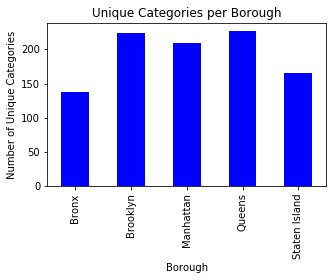

In [28]:
grouped_ny['Unique Categories'].plot(kind = 'bar', color = 'blue', figsize = (5,3), rot = 90)

plt.title('Unique Categories per Borough')
plt.ylabel('Number of Unique Categories')
plt.xlabel('Borough')

plt.show()

In [24]:
borough_score = grouped_ny[['Density', 'Unique Categories']]
borough_score['Borough Score'] = 0.4*grouped_ny['Density']+0.6*grouped_ny['Unique Categories']
borough_score

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Density,Unique Categories,Borough Score
Borough,,,
Bronx,16.192308,137,88.676923
Brooklyn,17.328571,224,141.331429
Manhattan,19.950000,209,133.380000
Queens,15.419753,227,142.367901
Staten Island,11.190476,166,104.076190


It looks like Queens is the winner! Now let's further explore Queens on the Neighborhood level.

In [44]:
#Queens_df = None

In [28]:
Queens_df = newyork_venues[newyork_venues['Borough']=='Queens'].reset_index(drop=True)
Queens_df.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Queens,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Queens,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Queens,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
3,Queens,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym
4,Queens,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop


In [45]:
Queens_df.shape

(1249, 8)

In [64]:
# one hot encoding
queensonehot = pd.get_dummies(Queens_df[['Venue Category']], prefix="", prefix_sep="")
queensonehot.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# add neighborhood column back to dataframe
queensonehot['Neighborhood'] = Queens_df['Neighborhood']
#queens_onehot= pd.concat([queens_onehot, Queens_df['Neighborhood']], axis =1)
queensonehot.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
queens_grouped = queensonehot.groupby('Neighborhood').mean().reset_index()
queens_grouped.head(10)

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Arverne,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
1,Astoria,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.05,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
2,Astoria Heights,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
3,Auburndale,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.05,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
4,Bay Terrace,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.05,0.000000
5,Bayside,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.05,0.0,0.00,0.000000
6,Bayswater,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
7,Beechhurst,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.071429
8,Bellaire,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
9,Belle Harbor,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000


In [67]:
queens_grouped.shape

(81, 227)

Now let's create the new dataframe and display the top 10 venues for each neighborhood. This will make it easy for the tourist to chose the best destination venue in the target neighborhood(s), and definetly sapres the research time.

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [93]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Sandwich Place,Coffee Shop,Pizza Place,Bus Stop,Café,Board Shop,Bed & Breakfast,Beach
1,Astoria,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
2,Astoria Heights,Deli / Bodega,Playground,Bakery,Bus Station,Plaza,Business Service,Supermarket,Bowling Alley,Gourmet Shop,Burger Joint
3,Auburndale,Italian Restaurant,Miscellaneous Shop,Comic Shop,Supermarket,Noodle House,Korean Restaurant,Bar,Toy / Game Store,Fast Food Restaurant,Furniture / Home Store
4,Bay Terrace,Cosmetics Shop,Lingerie Store,Clothing Store,American Restaurant,Bakery,Gluten-free Restaurant,Pizza Place,Supermarket,Weight Loss Center,Mobile Phone Shop


In [94]:
neighborhoods_venues_sorted.shape

(81, 11)

Let's Cluster these neighborhoods to simplify the task of selecting neighborhoods to visit accoding to the tourist's taste.

In [95]:
df_clusters = queens_grouped.drop('Neighborhood',1)
df_clusters.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.05,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.05,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.05,0.0


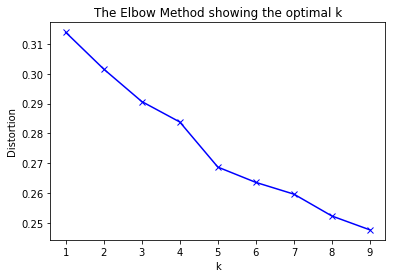

In [97]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

It looks like we could cluster the data into 4 or 5 clusters. Let's go with k = 4.

In [98]:
# set number of clusters
kclusters = 4

queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [99]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Queens_merged = Queens_df

# merge Queens_grouped with Queens_df to add latitude/longitude for each neighborhood
Queens_merged = Queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Queens_merged.head() # check the last columns!

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
1,Queens,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
2,Queens,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
3,Queens,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
4,Queens,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop


In [85]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7498243, -73.7976337.


In [100]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = mpl.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Queens_merged['Neighborhood Latitude'], Queens_merged['Neighborhood Longitude'], Queens_merged['Neighborhood'], Queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [101]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 0, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1019,Brookville,40.660153,-73.751554,Deli / Bodega,0,Deli / Bodega,Dance Studio,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market,Fast Food Restaurant,Farmers Market


In [107]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 1, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]].head(10)

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,40.767348,-73.917897,Brazilian Restaurant,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
1,Astoria,40.769856,-73.917012,Gourmet Shop,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
2,Astoria,40.769404,-73.918977,Gym,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
3,Astoria,40.769114,-73.912403,Gym,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
4,Astoria,40.769198,-73.919253,Gourmet Shop,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
5,Astoria,40.767200,-73.918104,Seafood Restaurant,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
6,Astoria,40.768077,-73.911561,Middle Eastern Restaurant,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
7,Astoria,40.766108,-73.913224,Martial Arts Dojo,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
8,Astoria,40.765835,-73.914647,Pub,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop
9,Astoria,40.768544,-73.911248,Dessert Shop,1,Seafood Restaurant,Gym,Gourmet Shop,Pub,Bakery,Greek Restaurant,Martial Arts Dojo,Middle Eastern Restaurant,Falafel Restaurant,Dessert Shop


In [105]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 2, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
734,Breezy Point,40.559201,-73.927213,Monument / Landmark,2,Beach,Monument / Landmark,Bus Stop,Trail,Yoga Studio,Eye Doctor,Food Court,Food & Drink Shop,Food,Flower Shop
735,Breezy Point,40.558499,-73.922276,Trail,2,Beach,Monument / Landmark,Bus Stop,Trail,Yoga Studio,Eye Doctor,Food Court,Food & Drink Shop,Food,Flower Shop
736,Breezy Point,40.556696,-73.929498,Beach,2,Beach,Monument / Landmark,Bus Stop,Trail,Yoga Studio,Eye Doctor,Food Court,Food & Drink Shop,Food,Flower Shop
737,Breezy Point,40.557172,-73.920272,Bus Stop,2,Beach,Monument / Landmark,Bus Stop,Trail,Yoga Studio,Eye Doctor,Food Court,Food & Drink Shop,Food,Flower Shop
738,Breezy Point,40.558670,-73.920380,Beach,2,Beach,Monument / Landmark,Bus Stop,Trail,Yoga Studio,Eye Doctor,Food Court,Food & Drink Shop,Food,Flower Shop
827,Rockaway Beach,40.582859,-73.822249,Beach,2,Beach,Spanish Restaurant,Bagel Shop,Food Stand,Fried Chicken Joint,Fast Food Restaurant,New American Restaurant,Beach Bar,Bar,Burrito Place
828,Rockaway Beach,40.584729,-73.819325,Pizza Place,2,Beach,Spanish Restaurant,Bagel Shop,Food Stand,Fried Chicken Joint,Fast Food Restaurant,New American Restaurant,Beach Bar,Bar,Burrito Place
829,Rockaway Beach,40.580438,-73.825593,Beach,2,Beach,Spanish Restaurant,Bagel Shop,Food Stand,Fried Chicken Joint,Fast Food Restaurant,New American Restaurant,Beach Bar,Bar,Burrito Place
830,Rockaway Beach,40.580586,-73.825922,Arepa Restaurant,2,Beach,Spanish Restaurant,Bagel Shop,Food Stand,Fried Chicken Joint,Fast Food Restaurant,New American Restaurant,Beach Bar,Bar,Burrito Place
831,Rockaway Beach,40.582840,-73.817758,Beach,2,Beach,Spanish Restaurant,Bagel Shop,Food Stand,Fried Chicken Joint,Fast Food Restaurant,New American Restaurant,Beach Bar,Bar,Burrito Place


In [106]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 3, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1018,Somerville,40.601131,-73.794403,Park,3,Park,Yoga Studio,Dance Studio,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market,Fast Food Restaurant,Farmers Market


It appears that the neighborhoods in Queens are mostly similar in venue types, with the exception of Somerville and Brookville, which each fall under 1 unique cluste, making them interesting to dicover how different they are from the rest. With respect to all other neighborhood, it can be concluded that choosing which neighborhood(s) to visit in each cluster (clusters with labels 1 and 2) shouldn't be a difficult task, which spares the decision-taking time for the tourist and empowers spontaneity, making the trip more exciting.